In [136]:
#The necessary libraries are imported

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack
from astropy.io import fits
from astropy.coordinates import Angle

import numpy as np
import glob 
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import cartopy.crs as ccrs

In [138]:
def eq(ele):
    
    # The script asks the user for the coordinates and radius
    
    ra,dec,radius = None,None,None
    
    while ra is None or not (180 <= ra <= 300):
        try:
            ra = float(input("Enter the RA coordinate in degrees (180 to 300): "))
        except ValueError:
            print("You must enter a number")
        
    while dec is None or not (-80 <= dec <= 0):
        try:
            dec = float(input("Enter the DEC coordinate in degrees (-80 to 0): "))
        except ValueError:
            print("You must enter a number")
            
    while radius is None or not (0. < radius <= 10.):
        try:
            radius = float(input("Enter the radius in degrees (0 to 10): "))
        except ValueError:
            print("You must enter a number")
    
    #guardamos la ra y dec para más adelante
    center = ra, dec
    
    #transformación de la coordenada ingresada
    coord_eq = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    
    return coord_eq, radius, center

def gal(ele):
    
    # The script asks the user for the coordinates and radius
    
    l, b, radius = None,None,None
    
    while l is None or not (0 <= l <= 360):
        try:
            l = float(input("Enter the galactic longitude in degrees (0 to 360): "))
        except ValueError:
            print("You must enter a number")
        
    while b is None or not (-15 <= b <= 10):
        try:
            b = float(input("Enter the galactic latitude in degrees (-15 to 10): "))
        except ValueError:
            print("You must enter a number")
            
    while radius is None or not (0. < radius <= 10.):
        try:
            radius = float(input("Enter the radius in degrees (0 to 10): "))
        except ValueError:
            print("You must enter a number")
            
    #guardamos la ra y dec para más adelante
    center = l, b 
        
    coord_gal = SkyCoord(l=l*u.deg, b=b*u.deg, frame='galactic')
    
    return coord_gal, radius, center

#######################################################################

def loop_coordinates(files, coordinate_type, c_user, radius):
    # List of sources to find
    selected_data = []
    
    # List of files to use
    file_names = []
    
    for filename in files:
        data = Table.read(filename)
        
        # Find sources within the coordinates range specified by the user
        # Convert the coordinates of each source to SkyCoord objects
        if coordinate_type == "Equatorial":
            coord = SkyCoord(ra=data['ra']*u.deg, dec=data['dec']*u.deg, frame='icrs')
        elif coordinate_type == "Galactic":
            coord = SkyCoord(l=data['l']*u.deg, b=data['b']*u.deg, frame='galactic')
        
        # Calculate the angular distance between the user's coordinates and the coordinates of the file
        sep = coord.separation(c_user)
        
        # Select table rows that are within the radius specified by the user
        selected_data_file = data[sep <= radius*u.deg]
        
        # Add found sources to selected_data
        if len(selected_data_file) > 0:
            selected_data.append(selected_data_file)
            file_names.append(filename)
    
    # Concatenate selected data into a single table
    try:
        selected_data_all = vstack(selected_data)
    except ValueError:
        print("No se encontraron fuentes en el radio y coordenadas indicado")      
    
    return file_names, selected_data_all


In [139]:
def veri_n_save(ele, con_data):
    
    #Verificar valores repetidos en las listas y guardar el archivo
    
    if ele == "Equatorial":
        column_name = 'ra'
    elif ele == "Galactic":
        column_name = 'l'
    
    column_data = con_data[column_name]
    
    if len(column_data) != len(set(column_data)):
        print("There are repeated values in the list")
    else:
        print("There are NOT repeated values in the list")
        # The script writes the selected data to a new fits file
        con_data.write('new_file.fits', format='fits', overwrite=True)


In [140]:
def visual(ele, conca_data, radius, center_coords):

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Mollweide())

    if ele == "Equatorial":
        x_data, y_data = 'ra', 'dec'
        ax.set_xlabel('RA (degrees)')
        ax.set_ylabel('DEC (degrees)')
    elif ele == "Galactic":
        x_data, y_data = 'l', 'b'
        ax.set_xlabel('Galactic Longitude (degrees)')
        ax.set_ylabel('Galactic Latitude (degrees)')

    ra = conca_data[x_data]
    dec = conca_data[y_data]

    center_ra = center_coords[0]
    center_dec = center_coords[1]

    ax.scatter(ra, dec, s=0.1, transform=ccrs.PlateCarree())

    circle = Circle((center_ra, center_dec), radius,
                    linestyle='--', edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
    ax.add_patch(circle)

    ax.set_extent([center_ra - radius - 3, center_ra + radius + 3,
                   center_dec - radius - 3, center_dec + radius + 3], crs=ccrs.PlateCarree())

    ax.gridlines()
    
    # Add labels
    ax.set_title('Sources within {:.2f} degree radius'.format(radius))

    # Hide ticks
    ax.set_xticks([])
    ax.set_yticks([])

    print(f"The total number of sources in the sample: {len(conca_data)}")

    plt.show()

In [141]:
def total_map(ele, all_data):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='aitoff')

    if ele == "Equatorial":
        x_col, y_col = 'ra', 'dec'
        ax.set_xlabel('RA (degrees)')
        ax.set_ylabel('DEC (degrees)')
    elif ele == "Galactic":
        x_col, y_col = 'l', 'b'
        ax.set_xlabel('Galactic Longitude (degrees)')
        ax.set_ylabel('Galactic Latitude (degrees)')

    ra_rad = Angle(all_data[x_col], unit='degree').wrap_at(180 * u.deg).radian
    dec_rad = Angle(all_data[y_col], unit='degree').radian

    ax.scatter(ra_rad, dec_rad, s=0.1)
    ax.grid(True)

    print(f"The total number of sources in the sample: {len(all_data)}")

    plt.show()

In [142]:
# Looking for the fits files in my directory
fits_files = glob.glob("*v1.fits")

Which coordinate system do you want to use? Enter 'Equatorial' or 'Galactic': Equatorial
You have chosen the Equatorial coordinate system.
Enter the RA coordinate in degrees (180 to 300): 267
Enter the DEC coordinate in degrees (-80 to 0): -18
Enter the radius in degrees (0 to 10): 2
There are NOT repeated values in the list
The total number of sources in the sample: 375341


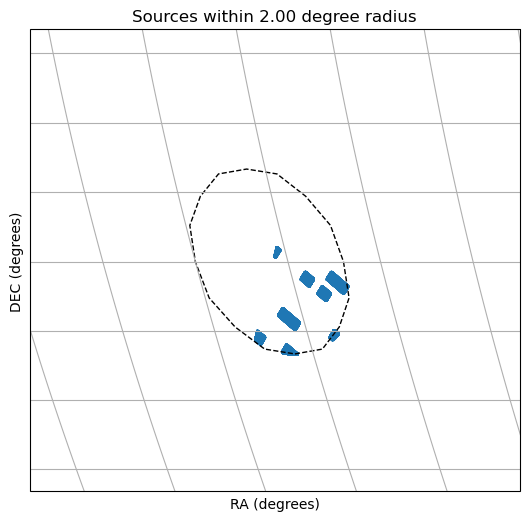

In [143]:
elec = None

while elec not in ["Equatorial", "Galactic"]:
    elec = input("Which coordinate system do you want to use? Enter 'Equatorial' or 'Galactic': ")

if elec == "Equatorial":
    print("You have chosen the Equatorial coordinate system.")
    #primera función que pide ingresar los parámetros al usuario
    c_eq, r_eq, center_eq = eq(elec)
    
    #con la siguiente función se seleccionan las fuentes dentro del radio ingresado
    #se entregan los nombres de estas fuentes y una lista de los datos obtenidos concadenatos 
    names_eq, con_data_eq = loop_coordinates(fits_files, elec, c_eq, r_eq)
    
    if len(con_data_eq) > 0:

        #Se verifica que no hayan fuentes repetidas y se guardan las fuentes encontradas en un nuevo fits
        veri_n_save(elec, con_data_eq)
        
        #Se visualizan las fuentes obtenidas
        visual(elec, con_data_eq, r_eq, center_eq)
    else:
        pass
    
elif elec == "Galactic":
    print("You have chosen the Galactic coordinate system.")
    c_gal, r_gal, center_gal = gal(elec)
    
    #segunda funcion
    names_gal, con_data_gal = loop_coordinates(fits_files, elec, c_gal, r_gal)
    
    if len(con_data_gal) > 0:
        
        #se verifica que no hayan fuentes repetidas
        veri_n_save(elec, con_data_gal)
        
        #cuarta funcion
        visual(elec, con_data_gal, r_gal, center_gal)
    else:
        pass

In [144]:
#Se concadenan los datos de todos los fits para realizar el mapa de todas las fuentes

from astropy.table import Table

total = []
file_names_2 = []

# Loop through each file
for filename in fits_files:
    data = Table.read(filename, format='fits')
    total.append(data)
    file_names_2.append(filename)
    
# Concatenate all the selected data into a single table
selected_data_all = vstack(total)

# Print the concatenated table
print(selected_data_all)

   sourceid   astfit_epochs ... phot_ks_std_mag phot_ks_n_phot
------------- ------------- ... --------------- --------------
8901664000002           575 ...      0.07251864            575
8901664000003           652 ...     0.054169454            652
8901664000013           407 ...     0.071528725            451
8901664000017           648 ...     0.045291275            648
8901664000018           601 ...     0.032006707            601
8901664000019           649 ...      0.03710479            649
8901664000023           638 ...      0.03602163            638
          ...           ... ...             ...            ...
9241616016074           337 ...      0.43004996            182
9241616016080           173 ...      0.54120445             86
9241616016082           144 ...      0.51044625             47
9241616016086           289 ...       0.3265382            245
9241616016091           284 ...       0.7361978            113
9241616016092           304 ...       0.4230812        

The total number of sources in the sample: 3338135


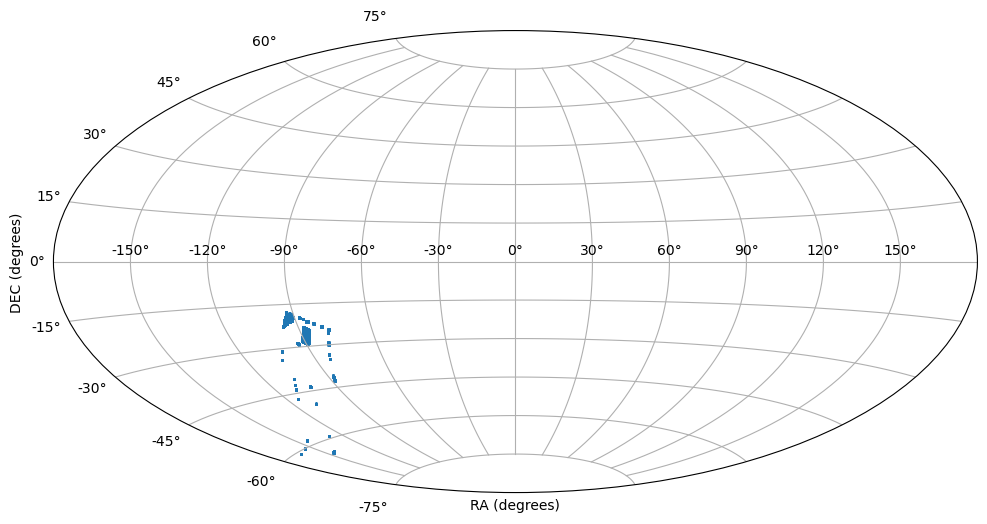

In [145]:
total_map(elec, selected_data_all)